In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from __future__ import print_function

import numpy as np
import tempfile

import ead.age as age
import ead.ead as ead
import rocnnet.rocnnet as rcn

from tf_rl.controller import HumanController
from tf_rl.simulation import KarpathyGame
from tf_rl import simulate


In [3]:
LOG_DIR = tempfile.mkdtemp()
print(LOG_DIR)

/var/folders/fs/cfs_ql391csfpxfsdxhmktw00000gn/T/tmpEGIKU9


In [4]:
current_settings = {
    'objects': [
        'friend',
        'enemy',
    ],
    'colors': {
        'hero':   'yellow',
        'friend': 'green',
        'enemy':  'red',
    },
    'object_reward': {
        'friend': 0.1,
        'enemy': -0.1,
    },
    'hero_bounces_off_walls': False,
    'world_size': (700,500),
    'hero_initial_position': [400, 300],
    'hero_initial_speed':    [0,   0],
    "maximum_speed":         [50, 50],
    "object_radius": 10.0,
    "num_objects": {
        "friend" : 25,
        "enemy" :  25,
    },
    "num_observation_lines" : 32,
    "observation_line_length": 120.,
    "tolerable_distance_to_wall": 50,
    "wall_distance_penalty":  -0.0,
    "delta_v": 50
}
savefile = 'karpathy_model.pbx'

In [5]:
# create the game simulator
g = KarpathyGame(current_settings)

In [6]:
class DQNControllerWrapper:
    def __init__(self, trainer):
        self.trainer = trainer

    def action(self, o):
        return self.trainer.action(o)

    def store(self, observation, action, reward, newobservation):
        self.trainer.store(observation, action, reward, newobservation)

    def training_step(self):
        self.trainer.train()

In [7]:
human_control = False

if human_control:
    # WSAD CONTROL (requires extra setup - check out README)
    current_controller = HumanController({b"w": 3, b"d": 0, b"s": 1,b"a": 2,}) 
else:
    # Brain maps from observation to Q values for different actions.
    # Here it is a done using a multi layer perceptron with 2 hidden
    # layers
    hiddens = [200, 200, g.num_actions]
    nonlins = [age.tanh, age.tanh, rcn.identity]
    brain = rcn.get_mlp(g.observation_size, hiddens, 'brain')

    learning_rate = 0.001
    bgd = rcn.get_rms_momentum(
       learning_rate = learning_rate,
       discount_factor = 0.9)
    # bgd = rcn.get_sgd(learning_rate)
    
    param = rcn.get_dqninfo(
        discount_rate = 0.99,
        exploration_period = 5000,
        max_exp = 1000,
        store_interval = 4,
        train_interval = 4)
    
    sess = ead.Session()
    current_controller = DQNControllerWrapper(rcn.DQNTrainer(brain, nonlins, sess, bgd, param))

In [8]:
FPS          = 30
ACTION_EVERY = 3
    
fast_mode = True
if fast_mode:
    WAIT, VISUALIZE_EVERY = False, 50
else:
    WAIT, VISUALIZE_EVERY = True, 1

    
try:
    simulate(
        simulation=g,
        controller=current_controller,
        fps=FPS,
        visualize_every=VISUALIZE_EVERY,
        action_every=ACTION_EVERY,
        wait=WAIT,
        disable_training=False,
        simulation_resolution=0.001,
        save_path=None)
except KeyboardInterrupt:
    print("Interrupted")

<tf_rl.utils.svg.Scene instance at 0x118f97cf8>

Interrupted


In [9]:
print('saving')
if current_controller.trainer.serialize_to_file(savefile):
    print('successfully saved to {}'.format(savefile))

saving
successfully saved to karpathy_model.pbx


# Average Reward over time

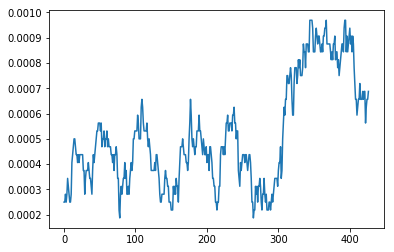

In [10]:
g.plot_reward(smoothing=100)

# Visualizing what the agent is seeing

Starting with the ray pointing all the way right, we have one row per ray in clockwise order.
The numbers for each ray are the following:
- first three numbers are normalized distances to the closest visible (intersecting with the ray) object. If no object is visible then all of them are $1$. If there's many objects in sight, then only the closest one is visible. The numbers represent distance to friend, enemy and wall in order.
- the last two numbers represent the speed of moving object (x and y components). Speed of wall is ... zero.

Finally the last two numbers in the representation correspond to speed of the hero.

In [11]:
g.__class__ = KarpathyGame
np.set_printoptions(formatter={'float': (lambda x: '%.2f' % (x,))})
x = g.observe()
new_shape = (x[:-4].shape[0]//g.eye_observation_size, g.eye_observation_size)
print(x[:-4].reshape(new_shape))
print(x[-4:])
g.to_html()

[[1.00 0.39 1.00 0.94 -0.67]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 0.56 1.00 -0.29 0.25]
 [1.00 0.61 1.00 -0.29 0.25]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]
 [0.59 1.00 1.00 0.73 -0.52]
 [1.00 1.00 1.00 0.00 0.00]
 [0.55 1.00 1.00 0.37 0.82]
 [1.00 1.00 1.00 0.00 0.00]
 [0.40 1.00 1.00 0.70 0.95]
 [0.36 1.00 1.00 0.70 0.95]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]
 [1.00 1.00 1.00 0.00 0.00]
 [0.91 1.00 1.00 -0.63 0.11]
 [1.00 0.41 1.00 0.94 -0.67]]
[0.12 1.87 -0.60 0.52]


<tf_rl.utils.svg.Scene instance at 0x118f97cf8>